In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [3]:
def append_ones(matrix):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

# MNIST dataset

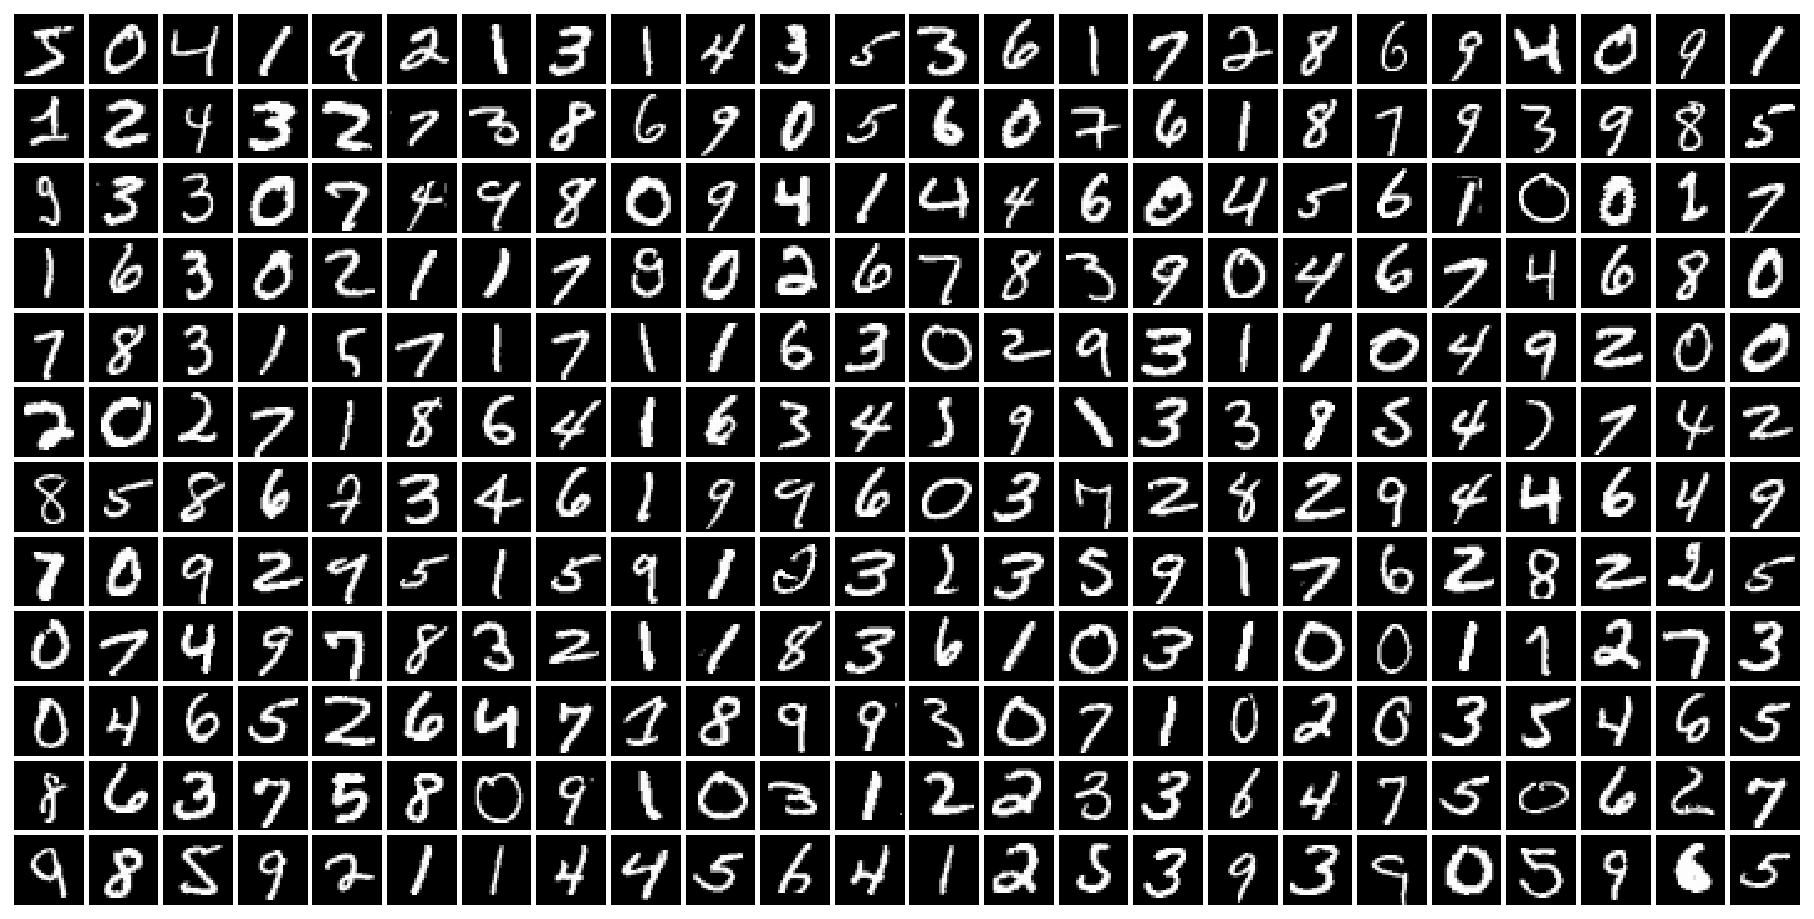

In [4]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# Restricted Boltzmann Machine & Contrastive Divergence algorithm

In [5]:
def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))

class Rbm:
    def __init__(self, visible_size, hidden_size, learning_rate):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        self.reset()
        
    def reset(self):
        self.W = np.random.normal(scale=0.01,
                                  size=(self.visible_size+1, self.hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0

## Algorytm Contrastive Divergence

$\newcommand{\vect}[1]{\mathbf{#1}}$
W sieci RBM gradient funkcji kosztu względem wag wyznaczamy zgodnie ze wzorem:

$\frac{\delta}{\delta w_{ij}} -\log P(\vect{v}) = -\mathbf{E}[v_i h_j \vert \vect{v}] + \mathbf{E}[v_i h_j]$

#### Faza pozytywna - odpowiada za część $\mathbf{E}[v_i h_j \vert \vect{v}]$

Tą część gradientu wyznaczamy przez wyliczenie iloczynów $v_i h_j$ pomiędzy elementami wektora obserwacji ($v_i$) a prawdopodobieństwami aktywacji w warstwie ukrytej ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_P = \vect{v}^T\sigma(\vect{vW})$

#### Faza negatywna - odpowiada za część $\mathbf{E}[v_i h_j]$

Rozpoczynamy od prawdopodobieństw aktywacji neuronów w warstwie ukrytej, które zostały wyznaczone w fazie pozytywnej. Na ich podstawie losujemy próbkę aktywacji w warstwie ukrytej:

$\vect{h} = \sigma (\vect{vW}) > [rand_1, rand_2, \dots, rand_m]$

Następnie losujemy próbkę aktywacji w warstwie widocznej:

$\vect{v}_1 = \sigma (\vect{hW}^T) > [rand_1, rand_2, \dots, rand_n]$

Aby wyznaczyć *fantazję* sieci RBM, powyższe próbki losujemy (naprzemiennie) $k$ razy (gdzie $k$ to parametr algorytmu CD-*k*):

$\vect{h}_{k-1} = \sigma (\vect{v}_{k-1}\vect{W}) > [rand_1, rand_2, \dots, rand_m]$, 
$\vect{v}_k = \sigma (\vect{h}_{k-1}\vect{W}^T) > [rand_1, rand_2, \dots, rand_n]$

Część negatywną gradientu wyznaczamy poprzez wyliczenie iloczynów $v_{k_i} h_j$ pomiędzy elementami wektora *fantazji* RBM ($v_{k_i}$) a prawdopodobieństwami aktywacji w warstwie ukrytej wyliczonymi dla tejże *fantazji* ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_N = \vect{v}_k^T\sigma(\vect{v}_k\vect{W})$


#### Aktualizacja macierzy wag RBM

Uczymy stochastycznym spadkiem wzdłuż gradientu:

$\phi_{t+1} \leftarrow \phi_t - \epsilon \nabla$

co dla gradientu RBM daje:

$W_{t+1} \leftarrow W_t + \epsilon \nabla_P - \epsilon \nabla_N$

In [29]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    positive_visible = minibatch
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))
    negative_visible = minibatch

    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    hk = sigmoid(negative_visible @ rbm.W) > rand(rbm.hidden_size + 1)
    vk = sigmoid(hk @ rbm.W.T) > rand(rbm.visible_size + 1)
    for i in range(k - 1):
        hk = sigmoid(vk @ rbm.W) > rand(rbm.hidden_size + 1)
        vk = sigmoid(hk @ rbm.W.T) > rand(rbm.visible_size + 1)

    gradient_negative = vk.T @ sigmoid(vk @ rbm.W)
    gradient_positive = positive_visible.T @ sigmoid(positive_visible @ rbm.W)

    rbm.W = rbm.W + rbm.learning_rate * (gradient_positive - gradient_negative)

    # raise Exception("Not implemented!")

# train_epoch(rbm, dataset)

#########################################

/var/folders/fg/xx2z_k855vgd5h06m_51dnsr0000gp/T/ipykernel_9577/2845635263.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-matrix))


############

### RBM reconstruction error

In [53]:
def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    visible = minibatch

    # how to calculate hidden layer?
    # hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    # that does not make much sense .. ;d
    hidden = sigmoid(visible @ rbm.W)
    visible_when_hidden = sigmoid(hidden @ rbm.W.T)
    hidden_again = sigmoid(visible_when_hidden @ rbm.W)

    error = np.sum(np.abs((np.array(hidden, dtype=np.float32) - np.array(hidden_again, dtype=np.float32))))
    return error

# reconstuction_error(rbm, dataset)

/var/folders/fg/xx2z_k855vgd5h06m_51dnsr0000gp/T/ipykernel_9577/2845635263.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-matrix))


91.189735

# RBM Training

In [54]:
import time

DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128
LEARNING_RATE = 0.1

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = np.reshape(mnist_train[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

rbm = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE)

In [55]:
def draw_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    filters = np.clip(filters, -1, 1)
    tiles(filters)

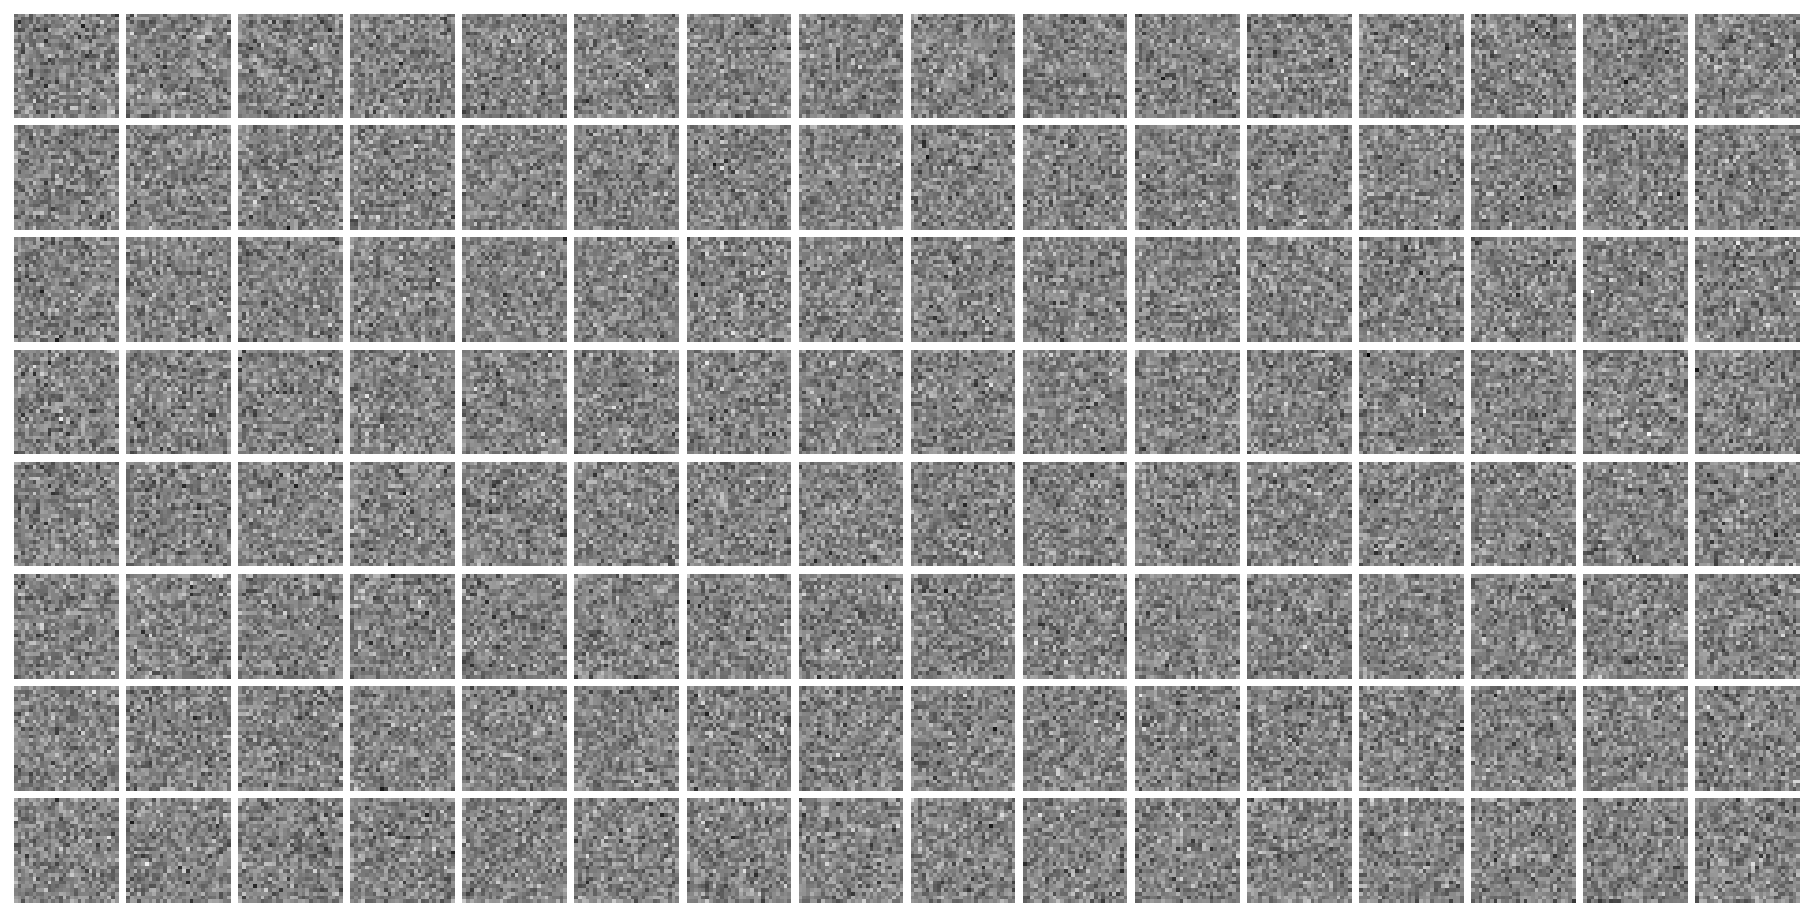

In [56]:
draw_filters(rbm)

In [67]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

def train_epoch(rbm, dataset):
    batches_limit = dataset.shape[0] / BATCH_SIZE
    for batch_idx, batch in enumerate(chunks(dataset, BATCH_SIZE)):
        cdk(rbm, batch, 1)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

rbm.reset()
for epoch in range(EPOCHS_COUNT):
    print("Epoch {}:".format(epoch + 1),  end="\t")
    
    start_time = time.time()
    train_epoch(rbm, dataset)
    
    elapsed = time.time() - start_time
    error = reconstuction_error(rbm, monitoring_set)
    print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))
    
print("Training finished!")

Epoch 1:	##########################################

/var/folders/fg/xx2z_k855vgd5h06m_51dnsr0000gp/T/ipykernel_9577/2845635263.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-matrix))


###########	elapsed: 0.26s, reconstruction error: 0.59
Epoch 2:	#####################################################	elapsed: 0.29s, reconstruction error: 0.49
Epoch 3:	#####################################################	elapsed: 0.29s, reconstruction error: 0.39
Epoch 4:	#####################################################	elapsed: 0.30s, reconstruction error: 0.33
Epoch 5:	#####################################################	elapsed: 0.26s, reconstruction error: 0.00
Epoch 6:	#####################################################	elapsed: 0.30s, reconstruction error: 0.45
Epoch 7:	#####################################################	elapsed: 0.29s, reconstruction error: 0.00
Epoch 8:	#####################################################	elapsed: 0.30s, reconstruction error: 0.11
Epoch 9:	#####################################################	elapsed: 0.28s, reconstruction error: 0.09
Epoch 10:	#####################################################	elapsed: 0.30s, reconstruction er

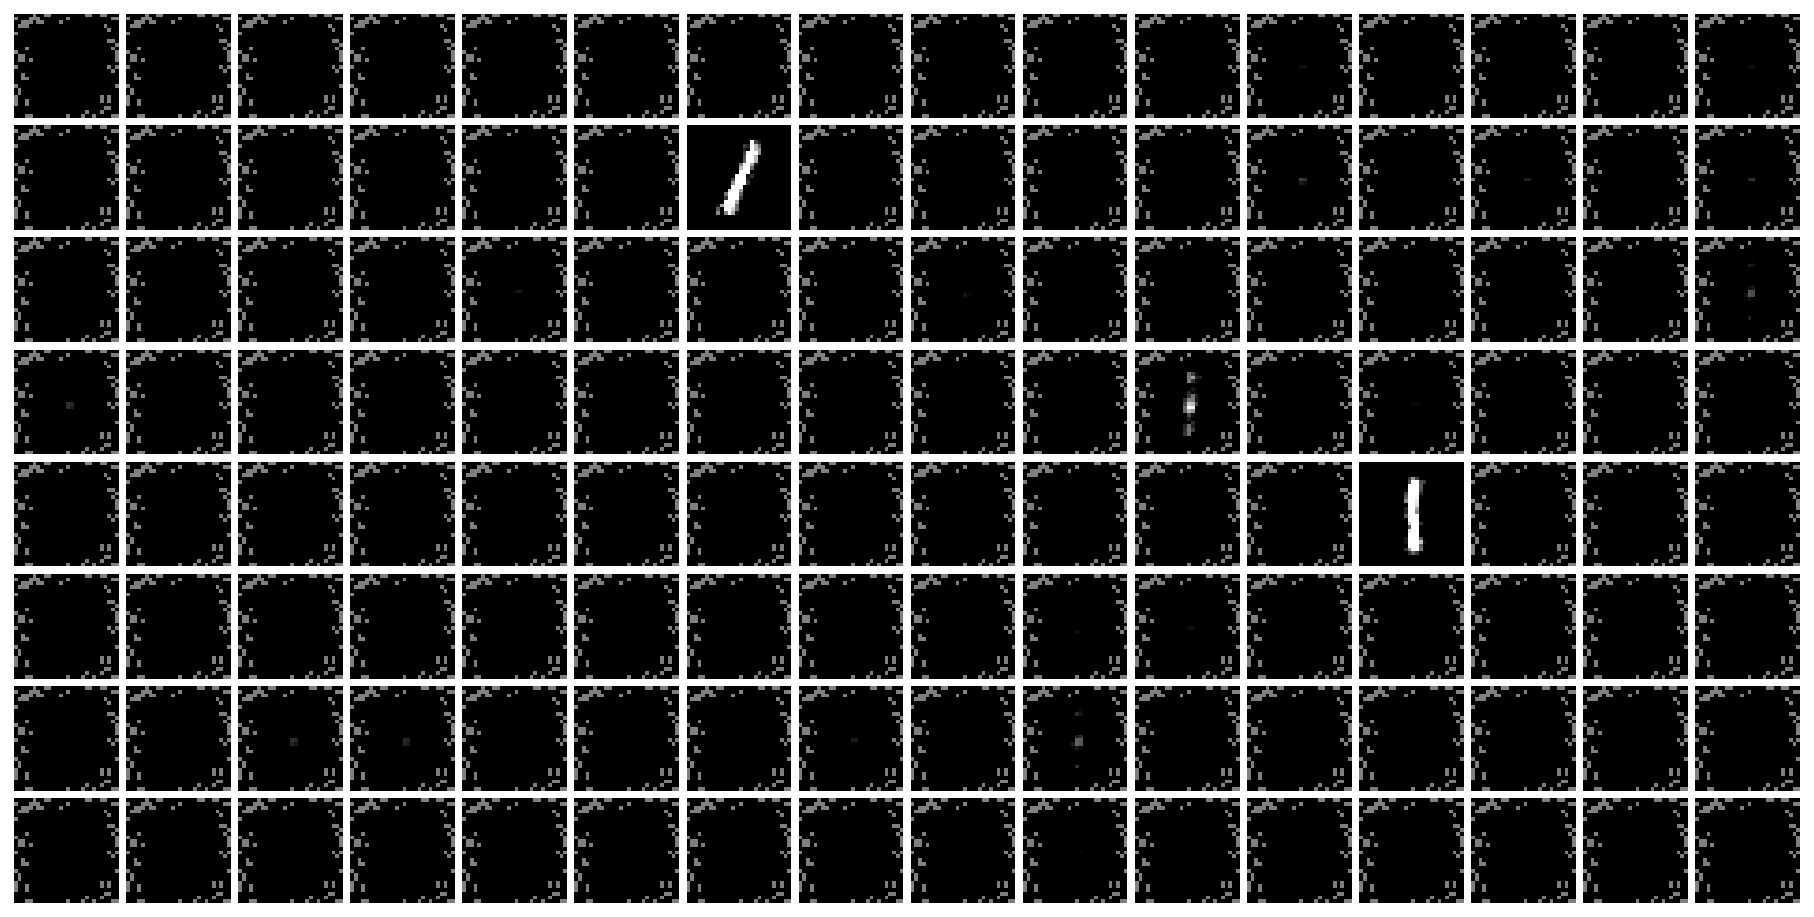

In [66]:
draw_filters(rbm)

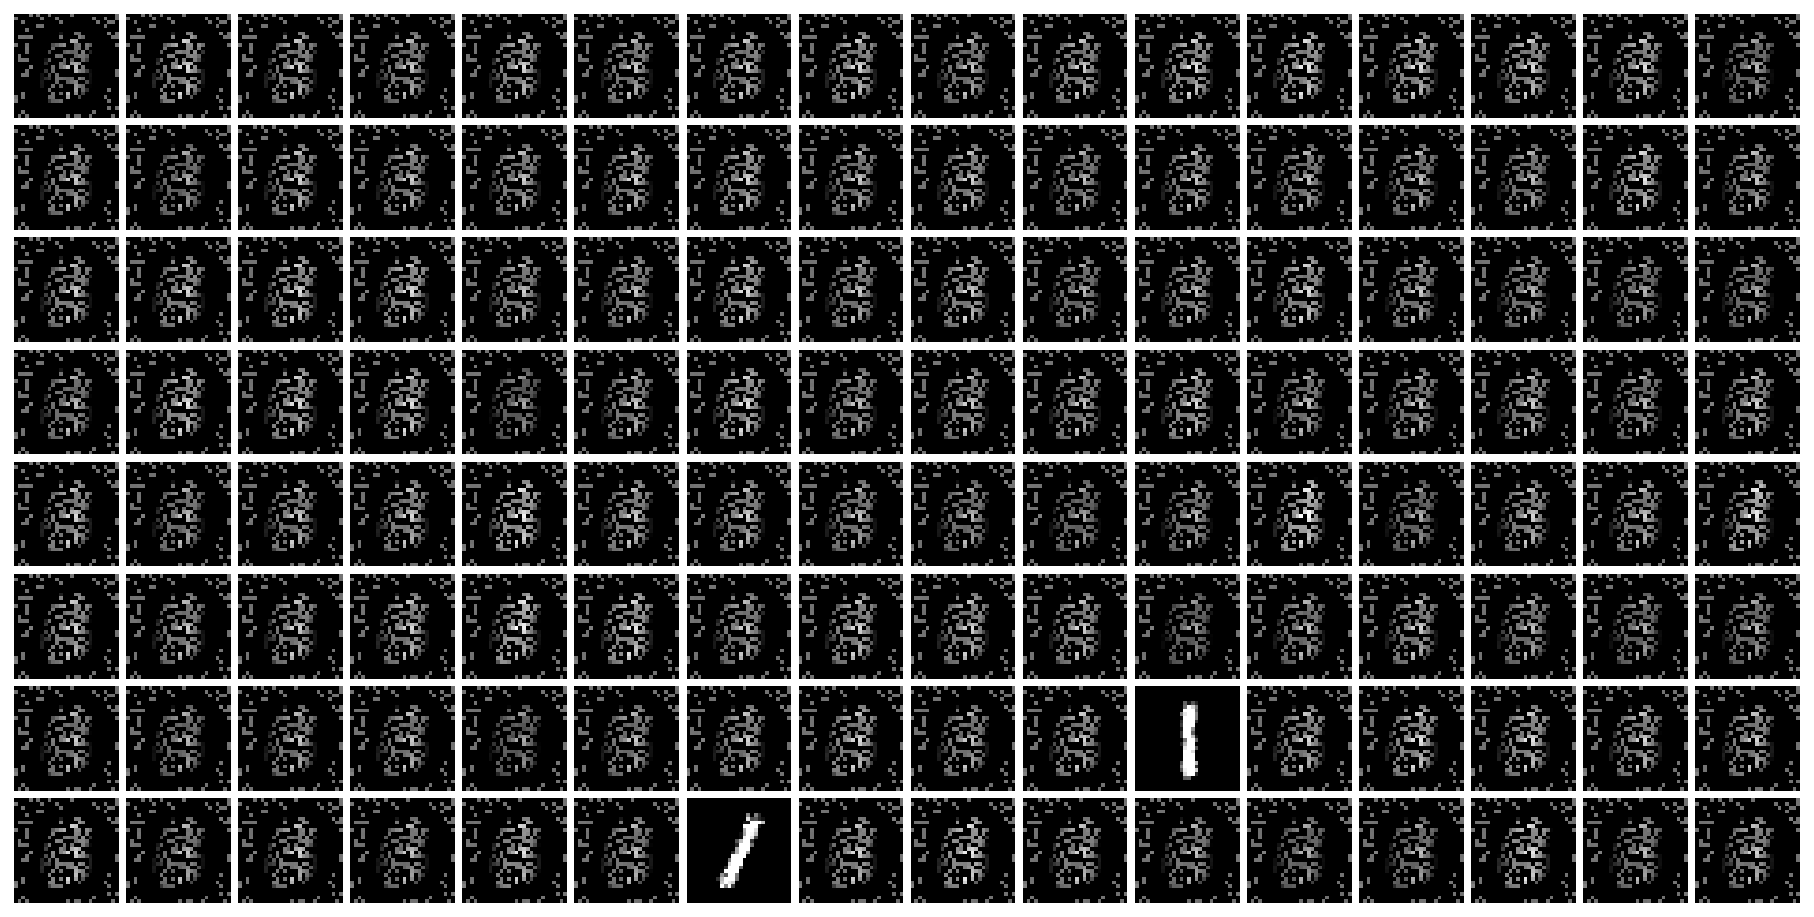

In [64]:
draw_filters(rbm)